# Mastering the Chessboard: A Data-Driven Approach
##### *Mohammad Durrani and Pranav Shah*

### Contents
1. [Introduction](##1.-Introduction)
2. [Required Tools](##2.-Required-Tools)
3. [About The Data](##3.-About-The-Data)
4. [Data Collection: Scraping](##4.-Data-Collection:-Scraping)
5. [Data Processing: Cleaning](##5.-Data-Processing:-Cleaning)
6. [Exploratory Data Analysis](##6.-Exploratory-Data-Analysis)
7. [Future Work and Conclusion](##7.-Future-Work-and-Conclusion)
8. [References and Additional Resources](##8.-References-and-Additional-Resources)

## 1. Introduction

In this data science project, we will navigate through the complete data science lifecycle, from data collection to training a machine learning model and uncovering valuable insights. Our main goal is to analyze the key characteristics that significantly impact the outcome of a chess game, identifying the most crucial factors contributing to victory.

As chess enthusiasts, we have explored various learning resources that emphasize different aspects of the game. However, there has been a lack of a data-driven consensus regarding the most impactful features that players should prioritize to maximize their chances of success.

This study aims to fill this gap by leveraging data science to provide players with evidence-based recommendations. By analyzing a vast array of chess game data, we will uncover patterns, strategies, and characteristics that distinguish winning players. Through machine learning techniques and statistical analysis, we will identify the key factors that greatly influence the outcome of a chess game.

The findings of this research will serve as a valuable resource for chess players of all skill levels, helping them focus their efforts on the most essential aspects of their gameplay. By providing a data-driven perspective on the qualities that matter in chess, we aim to change how players approach their training and help them make informed descisions.

Join us on this journey as we explore the world of chess analytics and uncover the secrets to success on the chessboard. Through this project, we will advance our understanding of the game and provide players with the tools and knowledge they need to improve their chess skills.

### Required Libraries and Imports

We use a variety of libraries in order to help us with data cleaning, visualization, and cleaning. Use ``pip3 install [packageName]`` to install the package locally.

* [Pandas](https://pandas.pydata.org/docs/): high performance data structures and analysis toolkit for data frames
* [NumPy](https://numpy.org/doc/stable/): scientific computing library, allowing for convenient and performant array / matrix operations
* [Matplotlib](https://matplotlib.org/): plotting library for data visualization
* [scikit-learn](https://scikit-learn.org/stable/): tool for machine learning pipelines
* [category-encoders](https://contrib.scikit-learn.org/category_encoders/): set of scikit-learn transformers to help with encoding categorical data
* [chess](https://python-chess.readthedocs.io/en/latest/): allows us to parse Portable Game Notation file (.pgn), which is how chess games are stored

#### Import Libaries

In [1]:
import chess.pgn
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report


### Background / Further Reading: Chess

In order to understand some of the motivations and terminiology in this study, we reccomend a familitarity with the game of chess. Reccomended resources include: 
* [Britannica: About Chess](https://www.britannica.com/topic/chess)
* [Chess.com: Chess Terms](https://www.chess.com/terms)
* [Chess.com: What Is The ELO Rating System?](https://www.chess.com/terms/elo-rating-chess#what-is-elo-rating)

## 3. About The Data

There are a wide variety of chess databases online that allow you to download and analyze chess games. For this study, we selected the Lichess open database for two main reasons:

1. Lichess is one of the largest online chess platforms, providing a vast collection of games played by players of various skill levels. This ensures a diverse and representative dataset for our analysis.

2. The Lichess database is freely accessible and regularly updated, allowing for easy acquisition and use of the data for research purposes.

The data was acquired from the website: https://database.lichess.org. Due to the size of the data (~30 GB of games / month), we restricted our analysis to March 2024. Once downloaded, it was divided into two CSV files: one file encompassing the complete dataset, and another smaller file suitable for sharing on GitHub. These files are identified as evaluations.csv and miniEvaluations.csv respectively.

The evaluations.csv file contains the full dataset, which includes a comprehensive set of features and game information for a large number of chess games. This dataset will be used for the main analysis and model training.

On the other hand, the miniEvaluations.csv file is a smaller subset of the full dataset, specifically curated for sharing on GitHub. This file contains a representative sample of chess games and their associated features, making it suitable for rapid iteration.

## 4. Data Collection: Scraping

At this stage, we need to take the data downloaded from the Lichess Database, filter out all of the games missing computer evaluations (approximately 90% of the database), and organize it into a csv with all the pertinent features. We required games with computer evaluations as this allows us to create deeper insights using blunders and other features. Note that 90% of the dataset being removed may sound significant, but considering ~90,000,000 million games are played monthly, this is ~9,000,000 games. This csv will be organized in a way where it can be directly read into a pandas dataframe.

In [2]:
pgnFilePath = r'./data/*.pgn'
#outputFilePath = "./evaluations.csv"
totalGameCount = 0
totalEvalGameCount = 0
fileList = [] 
#glob.glob(pgnFilePath)
rows_list = [] # list of dictionaries for each game 
for file in fileList:
    pgn = open(fileList[0])
    game = chess.pgn.read_game(pgn)
    while game != None:
        totalGameCount += 1
        variations = game.variations # list of either the eval or clock score
        if(totalGameCount % 2000 == 0): # print every 2000 games
            print("Total Game Count: ", totalGameCount)
            print("Eval Game Count: ", totalEvalGameCount)
        if(totalGameCount % 1000000 == 0):
            df = pd.DataFrame(rows_list) # add everything to the dataframe 
            df.to_csv(outputFilePath)
        if(len(variations) > 0 and 'eval' in variations[0].comment): # if this game was evaluated by a computer, add it
            totalEvalGameCount+=1
            h = game.headers
                
            # adding a dictionary is faster than appending to a dataframe 
            rows_list.append({
                "UTCDate": h.get("UTCDate", np.NaN),
                "UTCTime": h.get("UTCTime", np.NaN),
                'WhiteElo': h.get('WhiteElo', np.NaN),
                'BlackElo': h.get('BlackElo', np.NaN),
                "Opening": h.get("Opening", np.NaN),
                "ECO": h.get("ECO", np.NaN),
                'Result': h.get('Result', np.NaN),
                "Termination": h.get("Termination", np.NaN),
                "Variations": str(variations[0]) if variations else np.NaN,
                'WhiteRatingDiff': h.get('WhiteRatingDiff', np.NaN),
                'BlackRatingDiff': h.get("BlackRatingDiff", np.NaN)
            })

        # Iterator reading next game
        game = chess.pgn.read_game(pgn)          

## 5. Data Processing: Cleaning

During this stage of the Data Science lifecycle, we will be cleaning and preparing the data for analysis and machine learning. We will modify the dataframe to only include key features that we wish to train our model on. Most features will be comparing both players as we want to predict winning. Compared features will be represented from the perspective of the white player. Features that will be included relate to time, mistakes, positional traits, elo, moves, and of course the actual result. 

In [3]:


# Read data back in from csv and ignore the first column because it just contains the indicies.
# We only want white and black elo, opening category, result, and variations
smallDataset = "miniEvaluations.csv"
fullDataset = "evaluations.csv"
df= pd.read_csv(smallDataset, usecols=["WhiteElo", "BlackElo", "ECO", "Result", "Variations"])

# All data will be from the perspective of white 

# Get mistake differential from a game
def getMistakeDifferentials(variation):
    # Find all evaluations
    evalText = re.findall(r'%eval -?\d.\d*', variation)
    # Truncate text and get float eval value
    evalList = []
    for eval in evalText:
        evalList.append(float(eval.split(" ")[1]))

    # Find the mistake differential for white
    evalDifference = 0
    whiteBlunders = 0
    blackBlunders = 0
    whiteMistakes = 0
    blackMistakes = 0
    whiteInaccuracies = 0
    blackInaccuracies = 0
    for i in range(len(evalList)):
        if i != 0:
            evalDifference = evalList[i] - evalList[i-1]
        if abs(evalDifference) > 3:
            if i % 2 == 0:
                whiteBlunders += 1
            else:
                blackBlunders += 1
        elif abs(evalDifference) > 1:
            if i % 2 == 0:
                whiteMistakes += 1
            else:
                blackMistakes += 1
        elif abs(evalDifference) > 0.5:
            if i % 2 == 0:
                whiteInaccuracies += 1
            else:
                blackInaccuracies += 1
    blunderDifferential = whiteBlunders - blackBlunders
    mistakeDifferential = whiteMistakes - blackMistakes
    inaccuracyDifferential = whiteInaccuracies - blackInaccuracies
    return pd.Series({"BlunderDifferential" : blunderDifferential, "MistakeDifferential" : mistakeDifferential, 
                      "InaccuracyDifferential" : inaccuracyDifferential})

# Get time differential from a game
def getTimeDifferential(variation):
    # Find all clock text
    clockText = re.findall(r'%clk \d:\d{2}:\d{2}', variation)
    # Truncate text and get clock data in seconds
    clockList = []
    for clock in clockText:
        time = clock.split(" ")[1]
        hr = int(time.split(":")[0])
        min = int(time.split(":")[1])
        sec = int(time.split(":")[2])
        totalSeconds = hr * 3600 + min * 60 + sec
        clockList.append(totalSeconds)

    # Get clock differential
    whiteEndClock = 0
    blackEndClock = 0
    # If less than 2 moves, can't calculate time differential
    whiteBeginClock = 0
    if len(clockList) >= 2:
        whiteBeginClock = clockList[0]
        if len(clockList) % 2 == 0:
            whiteEndClock = clockList[-2]
            blackEndClock = clockList[-1]
        else:
            whiteEndClock = clockList[-1]
            blackEndClock = clockList[-2]
    timeDifferential = whiteEndClock - blackEndClock 

    return pd.Series({"TimeDifferential": timeDifferential, "TimeControl": whiteBeginClock})

def getMoves(variation):
    moves = re.findall(r'%eval -?\d.\d*', variation)
    # Even out moves to prevent it from giving away winner
    if len(moves) % 2 != 0:
        return len(moves) + 1
    return len(moves)

def getDevelopmentDifferential(variation):
    moves = re.findall(r'\d+\.+\s[\w-]+',variation)
    moveList = []
    for move in moves:
        moveList.append(move.split(" ")[1])
        
    whiteNonPawnMoves = 0
    whiteCastleTime = 0
    blackNonPawnMoves = 0
    blackCastleTime = 0
    for i in range(len(moveList)):
        if i<=24 and moveList[i][0] in ["N","B","R","Q","K","O"]:
            if i % 2 == 0:
                if moveList[i][0] == "O":
                    whiteCastleTime = i//2
                whiteNonPawnMoves+=1
            else:
                if moveList[i][0] == "O":
                    blackCastleTime = i//2
                blackNonPawnMoves+=1
    nonPawnMoveDifferential = whiteNonPawnMoves - blackNonPawnMoves
    castleTimeDifferential = whiteCastleTime - blackCastleTime
    return pd.Series({"DevelopmentDifferential": nonPawnMoveDifferential, "KingSafetyDifferential": castleTimeDifferential}) 
# Turn string result into a number result 
def getResultForWhite(result):
    if result == "0-1":
        return 0
    elif result == "1-0":
        return 1
    else:
        return 0.5
    
df[["BlunderDifferential","MistakeDifferential","InaccuracyDifferential"]] = df["Variations"].apply(getMistakeDifferentials)

df[["TimeDifferential","TimeControl"]] = df["Variations"].apply(getTimeDifferential)

df["Moves"] = df["Variations"].apply(getMoves)

df[["DevelopmentDifferential","KingSafetyDifferential"]] = df["Variations"].apply(getDevelopmentDifferential)

df["EloDifferential"] = df["WhiteElo"] - df["BlackElo"]

df["AverageElo"] = (df["WhiteElo"] + df["BlackElo"]) / 2

df["Result"] = df["Result"].apply(getResultForWhite)

df = df.drop(["Variations", "WhiteElo", "BlackElo"], axis=1)

pd.set_option('display.max_columns', None)
print(df.head())

   ECO  Result  BlunderDifferential  MistakeDifferential  \
0  B09     0.0                    0                    2   
1  C33     1.0                   -1                    0   
2  B12     1.0                   -1                   -2   
3  B13     1.0                    0                    1   
4  C40     1.0                    0                   -3   

   InaccuracyDifferential  TimeDifferential  TimeControl  Moves  \
0                       1               -26          180     36   
1                      -2                33          600     48   
2                       0               495         1800     48   
3                       2               531         1797     90   
4                      -3              -121          600     48   

   DevelopmentDifferential  KingSafetyDifferential  EloDifferential  \
0                       -1                      -4               97   
1                       -2                       0             -128   
2                      

## 6. Exploratory Data Analysis

Let's plot the relationship between each of our differentials and the average result. We'll use bar graphs as our result data is categorical and wouldn't be well represented with a scatter plot. While analyzing these graphs, we must keep in mind that a positive differential is advantageous for the Time, Elo, and Development differentials and a negative differential is advantageous for the Mistake and King Safety differentials. 

Text(0, 0.5, 'Mean Result')

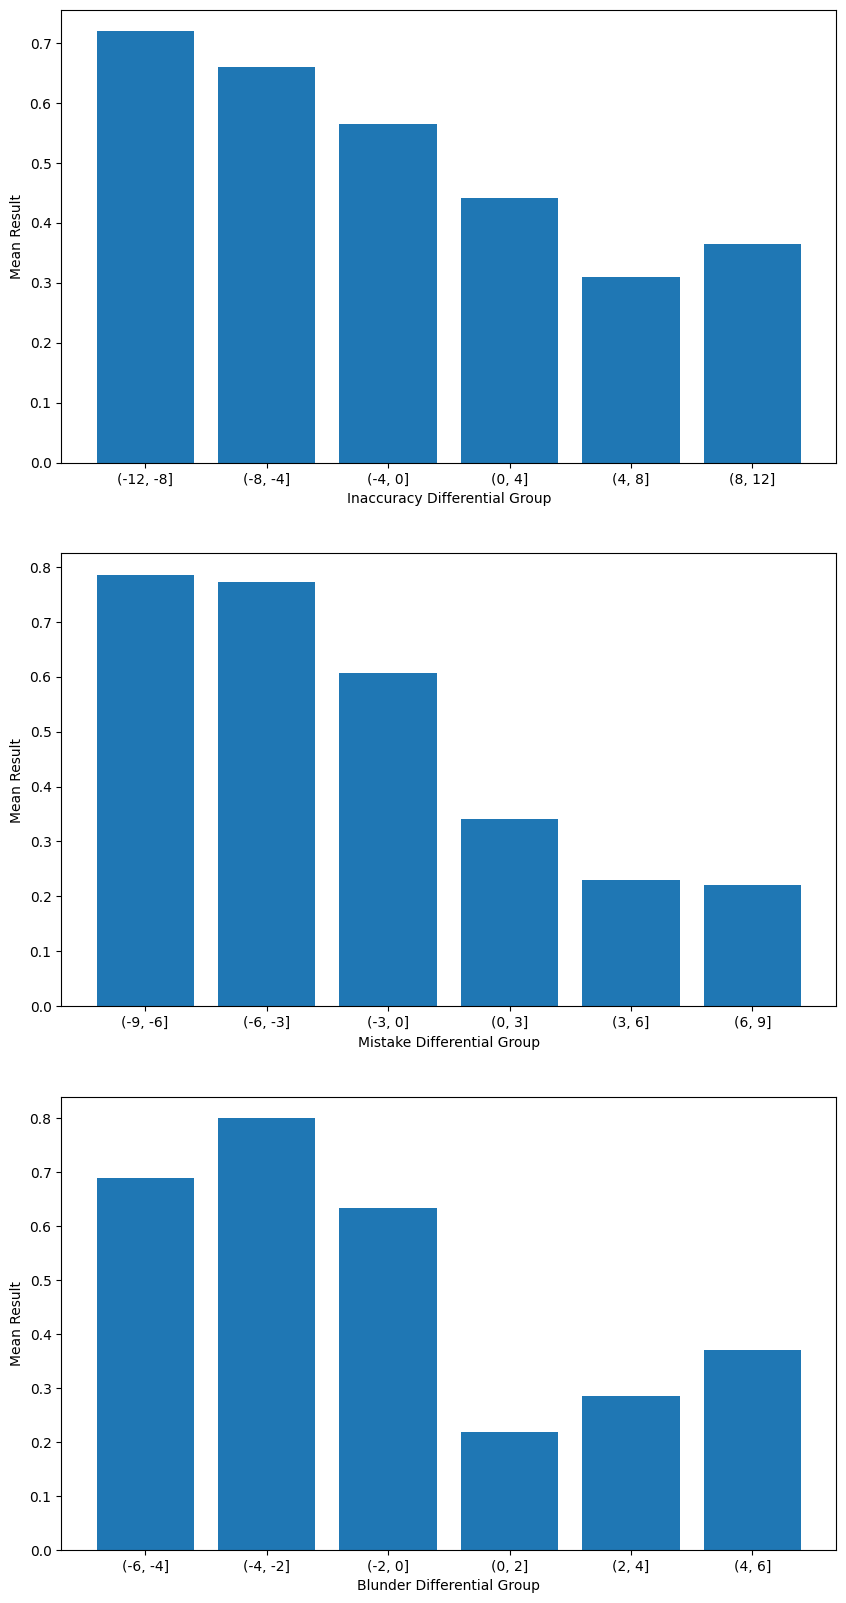

In [4]:


df["Inaccuracy Differential Group"] = pd.cut(df['InaccuracyDifferential'], bins=[-12,-8,-4,0,4,8,12], precision=0)
df["Mistake Differential Group"] = pd.cut(df['MistakeDifferential'], bins=[-9,-6,-3,0,3,6,9], precision=0)
df["Blunder Differential Group"] = pd.cut(df['BlunderDifferential'], bins=[-6,-4,-2,0,2,4,6], precision=0)

# Drop na values caused by values that don't fit the bins
inaccuracyGroups = df["Inaccuracy Differential Group"].dropna().unique().sort_values()
mistakeGroups = df["Mistake Differential Group"].dropna().unique().sort_values()
blunderGroups = df["Blunder Differential Group"].dropna().unique().sort_values()

fig, axes = plt.subplots(3, 1, figsize=(10, 20))


ax1 = axes[0]
x = range(len(inaccuracyGroups))
y = df.groupby("Inaccuracy Differential Group", observed=True)["Result"].mean()
ax1.bar(x,y)
ax1.set_xticks(x,inaccuracyGroups)
ax1.set_xlabel('Inaccuracy Differential Group')
ax1.set_ylabel('Mean Result')

ax2 = axes[1]
x = range(len(mistakeGroups))
y = df.groupby("Mistake Differential Group", observed=True)["Result"].mean()
ax2.bar(x,y)
ax2.set_xticks(x,mistakeGroups)
ax2.set_xlabel('Mistake Differential Group')
ax2.set_ylabel('Mean Result')

ax3 = axes[2]
x = range(len(blunderGroups))
y = df.groupby("Blunder Differential Group", observed=True)["Result"].mean()
ax3.bar(x,y)
ax3.set_xticks(x,blunderGroups)
ax3.set_xlabel('Blunder Differential Group')
ax3.set_ylabel('Mean Result')



It seems that making less errors does influence winning. However, at extreme error differentials in the graphs, there were results contradicting the overall trend. This was most likely because of the low sample size for those differentials groups.

Text(0, 0.5, 'Mean Result')

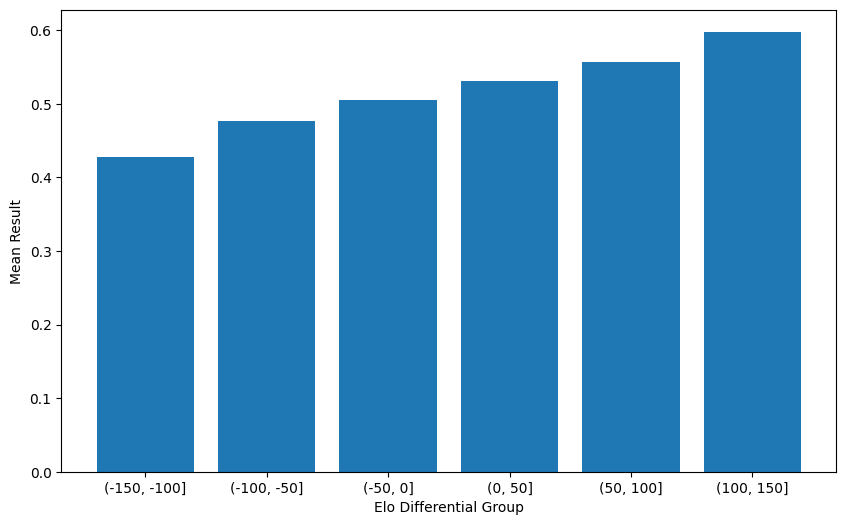

In [5]:
bins = [-150,-100,-50,0,50,100,150]
df["EloGroup"] = pd.cut(df['EloDifferential'], bins=bins, precision=0)

# Drop na values caused by values that don't fit the bins
groups = df["EloGroup"].dropna().unique().sort_values()

x = range(len(groups))
y = df.groupby("EloGroup", observed=True)["Result"].mean()
plt.figure(figsize=(10,6))
plt.bar(x, y)

plt.xticks(x, groups)
plt.xlabel('Elo Differential Group')
plt.ylabel('Mean Result')


The Elo Differential graph shows that elo has a clear correlation towards winning. The greater the differential between the player and their opponent, the greater the chance of winning. However elo doesn't impact the game significantly, at least not within the elo range shown. As long as players were in that elo range they were only at a less than 10% disadvantage/advantage. This is much different from the error graphs where having the mistake advantage could increase chances of winning by more than 30%.

Text(0, 0.5, 'Mean Result')

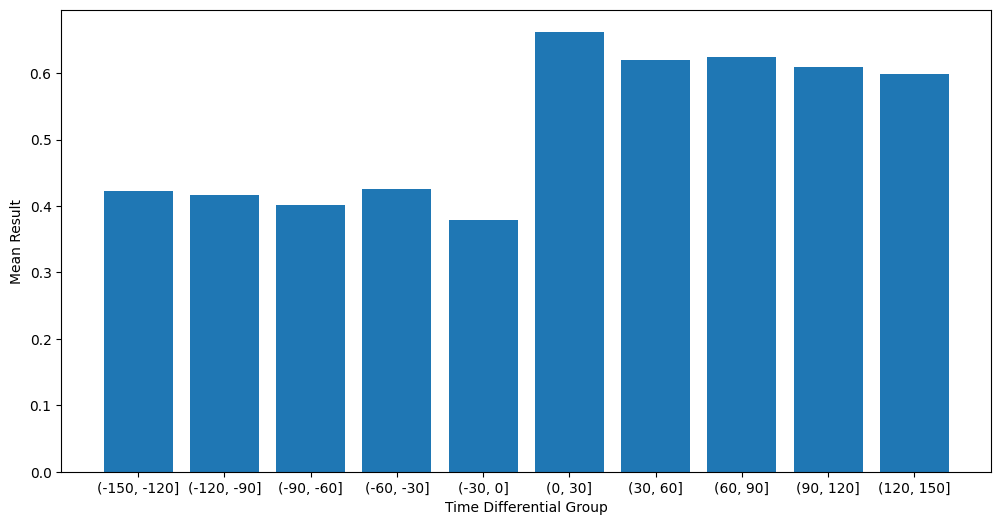

In [6]:
bins = [-150,-120,-90,-60,-30,0,30,60,90,120,150]
df["TimeGroup"] = pd.cut(df['TimeDifferential'],bins=bins, precision=0)

# Drop na values caused by values that don't fit the bins
groups = df["TimeGroup"].dropna().unique().sort_values()

x = range(len(groups))
y = df.groupby("TimeGroup", observed=True)["Result"].mean()
plt.figure(figsize=(12,6))
plt.bar(x, y)
plt.xticks(x, groups)
plt.xlabel('Time Differential Group')
plt.ylabel('Mean Result')

According to the graph, it seems that the only factor that influences winning is whether the player has the time advantage, not the quantity of that advantage. This makes sense as games can be won on time, so a significant decline in results can only be seen near 0. 

Text(0, 0.5, 'Mean Result')

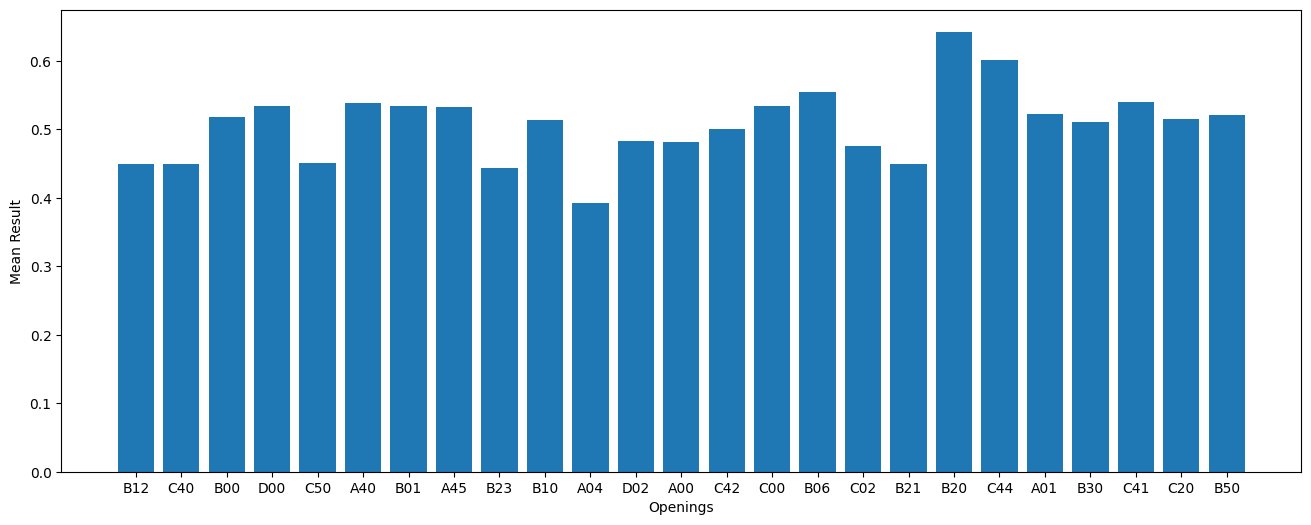

In [7]:
# Filter our df by openings that have at least 10000 games played, approximately 1% of the dataset. 
# We want frequently played openings because unusual openings have a large variance to their win percentage.
value_counts = df["ECO"].value_counts()

filtered_values = value_counts[value_counts > len(df.index)*.01].index
filtered_df = df[df['ECO'].isin(filtered_values)]

groups = filtered_df['ECO'].unique()

x = range(len(groups))
y = filtered_df.groupby("ECO", observed=True)["Result"].mean()
plt.figure(figsize=(16,6))
plt.bar(x, y)
plt.xticks(x, groups)
plt.xlabel('Openings')
plt.ylabel('Mean Result')

We filtered the data to only include openings that accounted for at least 1% of games in our database to get results with a low variance. The results show that openings do have a small impact on winning. The least and most winning openings differed by about 20%, with most openings hovering close to the 50% win rate.

Text(0, 0.5, 'Mean Result')

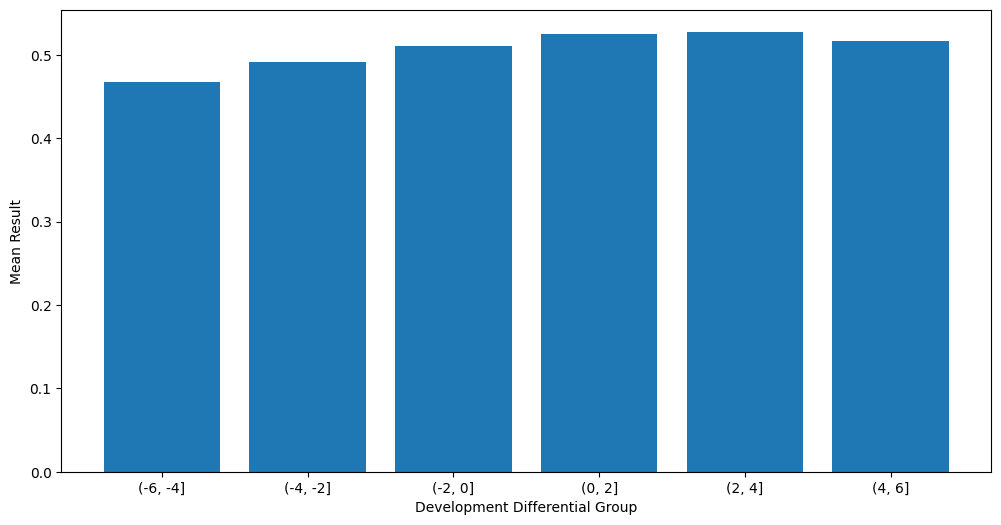

In [8]:
bins = [-6,-4,-2,0,2,4,6]
df["DevelopmentGroup"] = pd.cut(df['DevelopmentDifferential'],bins=bins, precision=0)

# Drop na values caused by values that don't fit the bins
groups = df["DevelopmentGroup"].dropna().unique().sort_values()

x = range(len(groups))
y = df.groupby("DevelopmentGroup", observed=True)["Result"].mean()
plt.figure(figsize=(12,6))
plt.bar(x, y)
plt.xticks(x, groups)
plt.xlabel('Development Differential Group')
plt.ylabel('Mean Result')

As we can see, like elo differential, development differential has a small but present impact on win rate. Players who spend less time moving their pawns and more developing their major pieces come out ahead after the opening.

Text(0, 0.5, 'Mean Result')

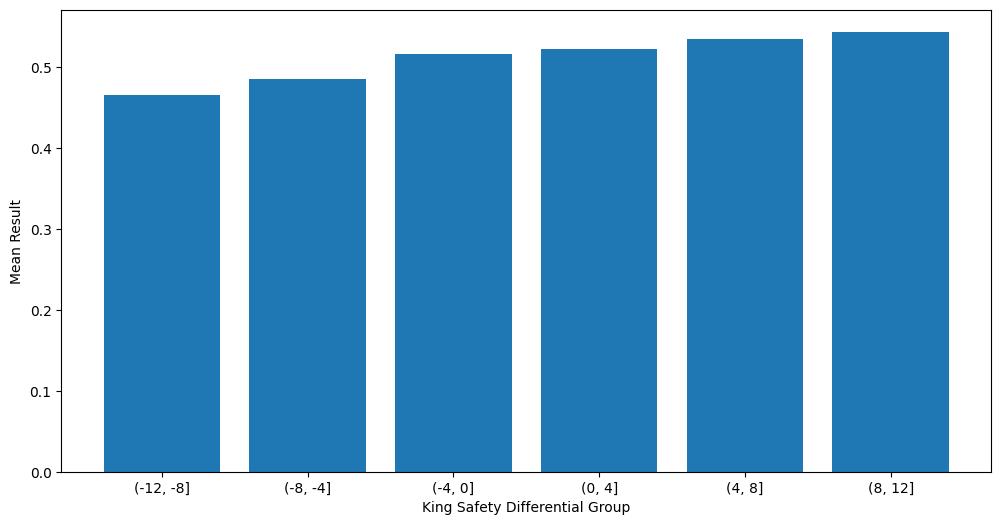

In [9]:
bins = [-12,-8,-4,0,4,8,12]
df["KingSafetyGroup"] = pd.cut(df['KingSafetyDifferential'],bins=bins, precision=0)

# Drop na values caused by values that don't fit the bins
groups = df["KingSafetyGroup"].dropna().unique().sort_values()

x = range(len(groups))
y = df.groupby("KingSafetyGroup", observed=True)["Result"].mean()
plt.figure(figsize=(12,6))
plt.bar(x, y)
plt.xticks(x, groups)
plt.xlabel('King Safety Differential Group')
plt.ylabel('Mean Result')

This graph has a similar trend as the development differential graph. Castling earlier in the game before the opportunity is lost generally increases one's king safety and win rate.

Let's explore how our features behave with one another to get a better insight into how they impact winning!

Slope for EloDifferential vs MistakeDifferential: -0.0021435697933253747
R^2 value 0.0032011971202323686
Slope for EloDifferential vs TimeDifferential: 0.04576733042463111
R^2 value 0.002036248672220742
Slope for TimeDifferential vs MistakeDifferential: -0.0010108434488335428
R^2 value 0.0007322937210155755


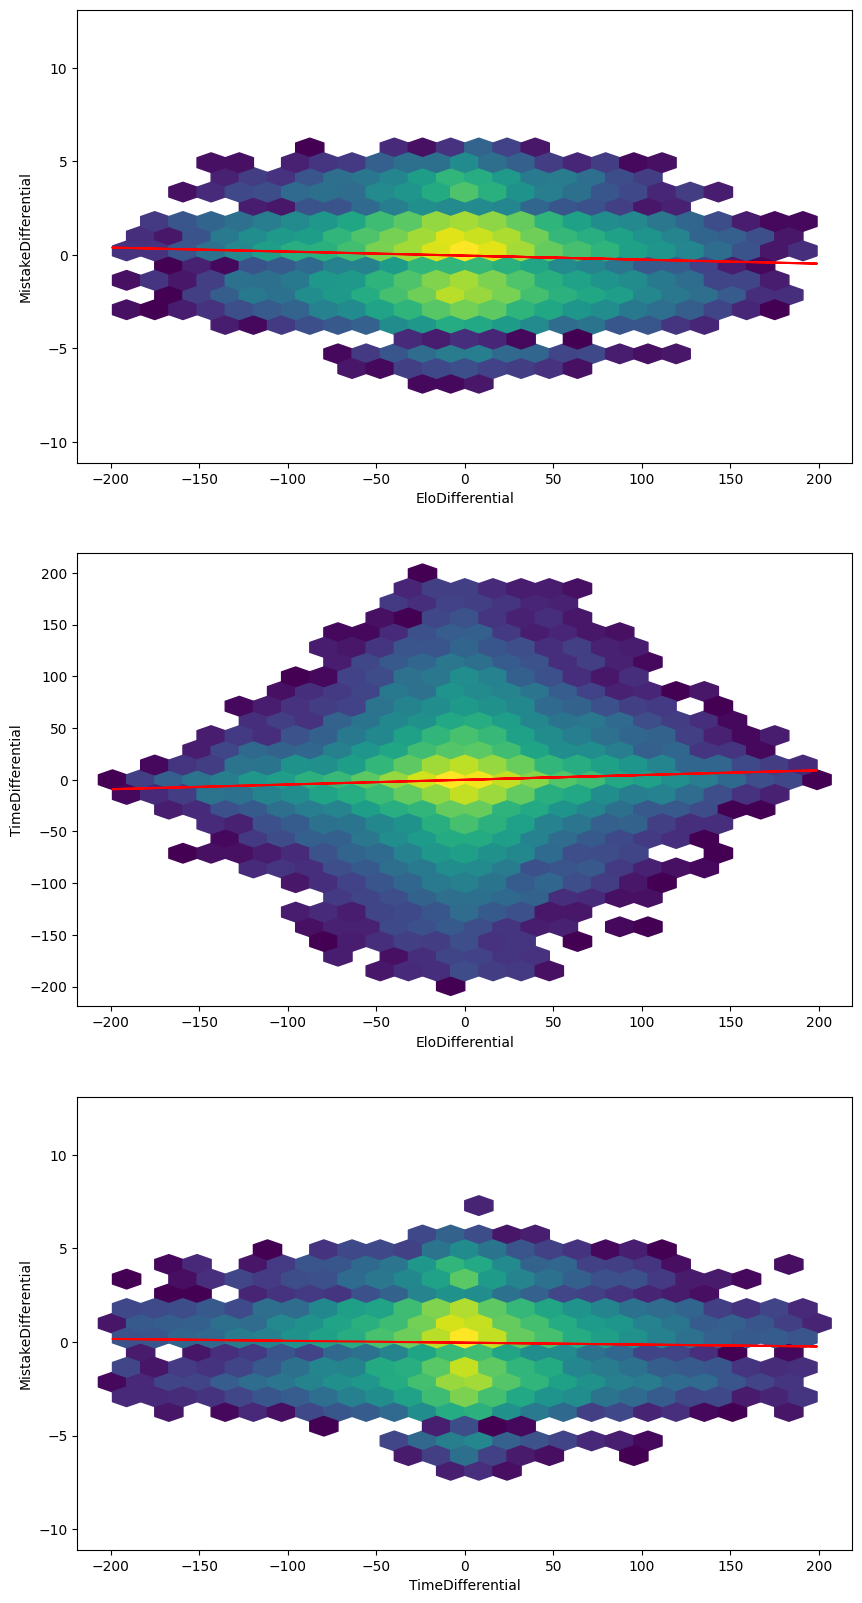

In [10]:
# Filter dataframe to remove outliers to make axes smaller
mincnt = 300
# If using small dataset
if len(df.index) < 100000:
    mincnt = 10

# Filtering dataframe to remove outliers because outliers will expand the range of the graphs significantly and 
# make trends in the graph tougher to notice.
filtered_df = df[(abs(df["EloDifferential"]) < 200) & (abs(df["TimeDifferential"]) < 200)]
fig, axes = plt.subplots(3, 1, figsize=(10, 20))

axesArr = [("EloDifferential","MistakeDifferential"),("EloDifferential","TimeDifferential"),("TimeDifferential","MistakeDifferential")]
for i, ax in enumerate(axes.flat):
    x, y = axesArr[i]
    # Decided to use a hexbin as there is a signficant amount of data, so scatter plots wouldnt work well
    ax.hexbin(filtered_df[x],filtered_df[y],gridsize=25,mincnt=mincnt, bins="log")
    # Getting a line of best fit using linear regression
    [m,b] = np.polyfit(filtered_df[x],filtered_df[y],1)
    # Plotting this line
    ax.plot(filtered_df[x],m*filtered_df[x]+b, 'r')
    
    print(f"Slope for {x} vs {y}: {m}")
    
    predicted_y = np.polyval([m,b], filtered_df[x])
    residuals = filtered_df[y] - predicted_y
    SSR = np.sum(residuals ** 2)
    
    mean_y = filtered_df[y].mean()
    difference = filtered_df[y] - mean_y
    SST = np.sum(difference ** 2)
    
    Rsquared = 1-(SSR/SST)
    print(f"R^2 value {Rsquared}")
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)

plt.show()


The graphs above provide the correlation between our features and give us a more nuanced look at the impact of the features on winning rates. Hexbin graphs were chosen as there is a signficant amount of data, so scatter plots wouldnt work well. We also used linear regression to draw a line of best fit for each of these graphs. Using this line of best fit, we calculated the R^2 value. As we can see, the incredibly low R squared values for each graph shows the lines inability to explain the variance.

The first graph between EloDifferential and MistakeDifferential shows that having a greater elo than your opponent can reduce your mistakes slightly. A close look at the hexbins shows this slight correlation. This makes sense intuitively as higher elo players are better than their opponents, and will make fewer mistakes. 

The second graph between EloDifferential and TimeDifferential also agrees with our past findings, having a greater elo will give a slight time advantage and therefore increase chances of winning. This graph also had a signficantly greater slope for its line of best fit than the other two, showing a much stronger correlation between these two characteristics. 

The third graph between TimeDifferential and MistakeDifferential, however, defies intuition. One would think that having a time disadvantage would cause a player to panic and make more mistakes, but there seems to be little to no correlation between the two variables. The slope of the line of best fit is about half that of the first graph and there is no noticable trend when looking at the hexbin graph. One explanation for this might be that games with a large time differential may end by time out, so mistakes wouldn't factor into the result. 

## 7. Machine Learning

Now that we have completed the data cleaning and visualization parts of the data science pipeline, we want to train a machine learning model that will allow us to perdict the winner of a chess game given certain features like ELO difference, time difference, blunders, etc., and then can examine the feature importance in order to show players which ones are having the greatest impact on determining the winner. We will be training a classifier (as we want to classify as win, loss, etc.) rather than performing regression. 

### Preliminary Reading: Classification and Categorical Encoding

We reccomend a familiarity with classification and categorical encoding to help understand this section. Reccomended resources include:

* [IBM: What is random forest?](https://www.ibm.com/topics/random-forest)
* [scikit-learn course: Encoding of categorical variables](https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline.html)


### Preparing Data For Training

Originally, the data for winning and losing is stored as a numerical value with 1.0 for winning, 0.0 for losing, and 0.5 for a tie. This is converted to a categorical label (rather than numerical) for training to allow for classification. 

In [11]:
def convertWinToCategory(val):
    res = ""
    match val:
        case 1.0:
            res = "Win"
        case 0.0:
            res = "Loss" 
        case 0.5:
            res = "Tie"
    return res

We first pick out all of the features we will be using in order to train our model. This includes king safety differential, development differential, average ELO, time control, moves, inaccuracy differential, mistake differential, blunder differential, time differential, elo differential, opening, and the result. These features are all explained in the sections above. After that, we want to limit ourselves to openings that make up at least 2% of the database, which helps us avoid the curse of dimensionality (there are hundreds of thousands of chess openings, making encoding difficult).

In [12]:
# extract necessary features for training
train_feat_df = df.loc[:,["KingSafetyDifferential","DevelopmentDifferential","AverageElo","TimeControl", "Moves", "InaccuracyDifferential", "MistakeDifferential", "BlunderDifferential", "TimeDifferential", "EloDifferential", "ECO", "Result"]]

# convert results to categorical values for training
train_feat_df["Result"] = train_feat_df["Result"].map(convertWinToCategory)

#retuns a df of the value counts of all the openings
value_counts = train_feat_df["ECO"].value_counts()

#filters all the values such that the count of their occurences needs to be greater than 2% of the dataset, and then cuts the others out of the training dataset
filtered_values = value_counts[value_counts > len(train_feat_df.index)*.02].index
train_feat_df = train_feat_df[train_feat_df['ECO'].isin(filtered_values)]

### Encoding Openings

Encoding the chess openings posed a significant challenge due to the vast number of possibilities, which can reach hundreds of thousands. Using one-hot encoding without filtering would introduce n new features, where n represents the number of openings, leading to the curse of dimensionality. To overcome this obstacle, we implemented a filtering process that limited the openings to those that constitute at least 2% of the dataset. This decision was based on the understanding that openings with a lower representation would not provide a statistically significant number of games to derive meaningful insights. Once the filtering process was complete, we applied one-hot encoding to the remaining openings, as they are categorical variables. This approach allowed us to effectively manage the dimensionality of the dataset while preserving the most relevant information for analysis.

In [ ]:
# Use pd.get_dummies to perform one-hot encoding
one_hot_enc_df = pd.get_dummies(train_feat_df["ECO"], prefix='ECO')
train_feat_df = pd.concat([train_feat_df, one_hot_enc_df], axis=1)
train_feat_df = train_feat_df.drop("ECO", axis = 1) #drop old opening column

### Choosing A Model

Now that the data has been prepared for training, a model has to be chosen. In order to do this, we trained a wide variety of classification models, did hyperparameter tuning and k-fold cross validation, and then saved the accuracy for each. This allows us to find the model with the highest accuracy and prescision for our needs. The accuracy of each model is then plotted.

RandomForestClassifier
GradientBoostingClassifier
AdaBoostClassifier


c:\Users\mdurr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


DecisionTreeClassifier
KNeighborsClassifier
SVC


c:\Users\mdurr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


GaussianNB
LogisticRegression


c:\Users\mdurr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MLPClassifier


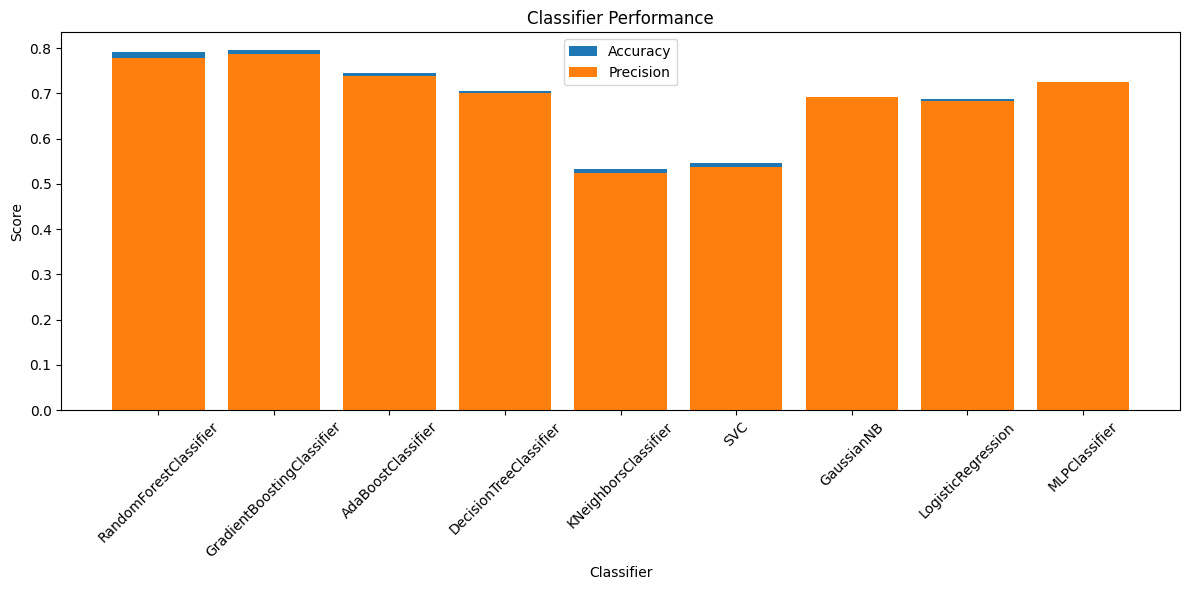

In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt


# set up all classifiers
classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    SVC(),
    GaussianNB(),
    LogisticRegression(),
    MLPClassifier()
]

# seperate out data into testing and training dataset
X = train_feat_df.drop("Result", axis=1)
y = train_feat_df["Result"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.25, random_state=42, shuffle=True)

results = []

#loop through all classifiers
for classifier in classifiers:
    clf_name = classifier.__class__.__name__
    clf = classifier
    
    #fit each classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # extract the accuracy and precsision
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    #save the results in a dictionary
    results.append({'classifier': clf_name, 'accuracy': accuracy, 'precision': precision})

# plot using matplot lib
accuracies = [result['accuracy'] for result in results]
precisions = [result['precision'] for result in results]
classifiers = [result['classifier'] for result in results]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(classifiers, accuracies, label='Accuracy')
ax.bar(classifiers, precisions, label='Precision')
ax.set_xlabel('Classifier')
ax.set_ylabel('Score')
ax.set_title('Classifier Performance')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the graph above, it is clear that the GradientBoostingClassifier performs the best with random forest being in close second, and KNeighbors performing the worst. This is also intuitive because gradient boosting and random forest are ensemble methods that combine multiple weak learners (descision trees in both cases) to create a strong learner. On the other hand, K-Nearest Neighbors (KNN) is a simpler algorithm that relies on the proximity of data points to make predictions. It may struggle with high-dimensional data and can be sensitive to the choice of the number of neighbors (k). 

Furthermore, gradient boosting is an iterative algorithm that progressively improves the model by focusing on the misclassified samples from previous iterations. This allows it to effectively handle difficult cases and achieve higher accuracy. This is what leads it to better performance over the random forest classifier. In contrast, KNN's performance heavily depends on the quality and relevance of the selected neighbors. If the neighbors are not representative of the true class distribution or if the features are not well-separated, KNN may struggle to make accurate predictions.

### Hyperparameter Optimization

After selecting the best model, we want to perform more rigorous hyperparameter optimization in order to get the best accuracy and prescision possible. We use GridSearchCV to perform an exhaustive search of the parameter space and then save the best perfoming model. For additional reading on hyperparamter optimization, please see:
* [Machine Learning Mastery: Guide to Hyperparameter Tuning](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)

In [46]:


parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error', 'friedman_mse'],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    }


# Create a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=parameters, cv=5, n_jobs=-1, verbose=True)
grid_search.fit(X_train, y_train)

# Print the best model and its hyperparameters
print("Best Model:")
best_model = grid_search.best_estimator_
print(best_model)

Fitting 5 folds for each of 84672 candidates, totalling 423360 fits


KeyboardInterrupt: 

In [44]:
best_model.fit(X_train, y_train) 
y_pred_rand = best_model.predict(X_test) 
print(classification_report(y_pred_rand, y_test)) 

              precision    recall  f1-score   support

        Loss       0.71      0.74      0.72      4776
         Tie       0.00      0.00      0.00         0
         Win       0.79      0.72      0.75      5790

    accuracy                           0.73     10566
   macro avg       0.50      0.49      0.49     10566
weighted avg       0.75      0.73      0.74     10566



c:\Users\mdurr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mdurr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mdurr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

### Finding the most impactful features

By looking at the most impactful features, we are able to see (generally) what matters the most when it comes to perdicting the winner of the game. This information is already a part of the scikit-learn model, so a plot is shown below.

In [16]:
# combine features and their imporances into a dataframe
important_features = zip(X.columns, best_model.feature_importances_)
imp_feat_df = pd.DataFrame(important_features)
imp_feat_df.rename(columns={0:'features',
                               1:'importance'},
                      inplace=True)

# sort by importance and reconfigure the index
imp_feat_df.sort_values(by=['importance'], inplace=True, ascending=False)
imp_feat_df.reset_index(inplace=True)
imp_feat_df.drop(['index'], axis=1, inplace=True)
imp_feat_df

,features,importance
0,BlunderDifferential,0.343769
1,MistakeDifferential,0.210394
2,TimeDifferential,0.117267
3,Moves,0.080014
4,TimeControl,0.056936
5,InaccuracyDifferential,0.044305
6,AverageElo,0.044162
7,EloDifferential,0.038189
8,KingSafetyDifferential,0.020215
9,DevelopmentDifferential,0.016496


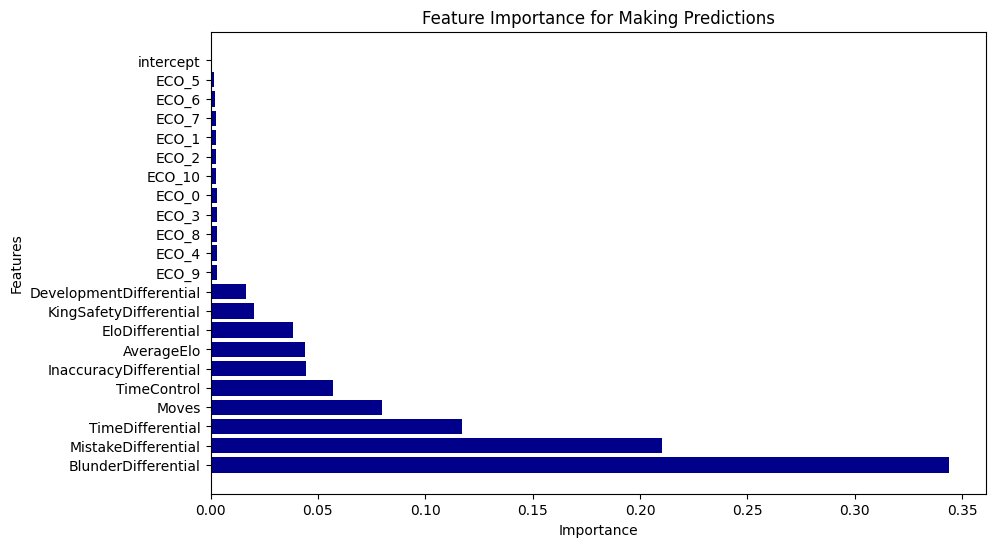

In [17]:
# plot using matplotlib
plt.figure(figsize=(10, 6))
plt.barh(imp_feat_df['features'], imp_feat_df['importance'], color='darkblue')

plt.xlabel('Importance')
plt.ylabel('Features')

plt.title('Feature Importance for Making Predictions')

plt.show()


Using the plot above, we can see that the blunder differential is the most impactful feature to perdicting the winner of a chess game. This is intuitive as the player who makes blunders means that their position worsens considerable but is also suprising, that it is significantly more impactful than ELO differential. 

### Benchmark

In order to do more benchmarking on the performance of our model, we will look at the confusion matrix in order to see prescision, accuracy, and recall in a more visual way. Additionally, we will compare against a baseline of random guessing and the heurisitic of "the player with the higher ELO will win".

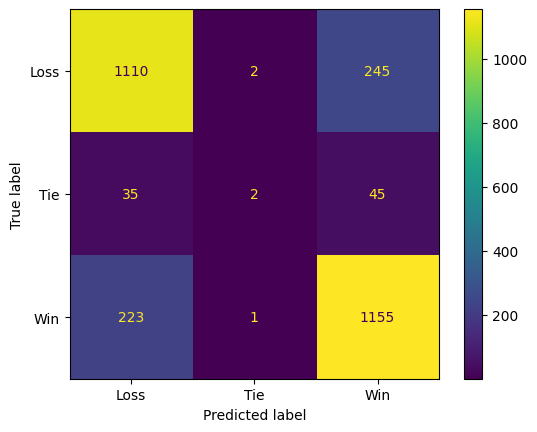

In [18]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred_rand, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=best_model.classes_)
disp.plot()

plt.show()

Now, we will compare our model against the baseline performance of guessing and the heuristic of "the player with the higher ELO wins".

In [19]:
tolerance = 10

bench1 = X_test['EloDifferential'].apply(lambda x: "Win" if x > tolerance else ("Loss" if x < -tolerance else "Tie"))

bench2 = np.random.choice(["Loss", "Tie", "Win"], size=len(X_test))

bench3 = y_pred

bench4 = y_pred_rand

ground_truth = y_test


data = {'Greater ELO Wins': bench1, 'Random Guess': bench2, 'predictions (no hyperparameter)': bench3, 'predictions (hyperparameter)': bench4,'ground_truth': ground_truth}
test_df = pd.DataFrame(data)

accuracy_bench1 = accuracy_score(test_df['ground_truth'], test_df['Greater ELO Wins'])
accuracy_bench2 = accuracy_score(test_df['ground_truth'], test_df['Random Guess'])
accuracy_bench3 = accuracy_score(test_df['ground_truth'], test_df['predictions (no hyperparameter)'])
accuracy_bench4 = accuracy_score(test_df['ground_truth'], test_df['predictions (hyperparameter)'])


print(f"Accuracy of Greater ELO Wins Benchmark: {accuracy_bench1*100:.2f}%")
print(f"Accuracy of Randomly Guessing Winner: {accuracy_bench2*100:.2f}%")
print(f"Accuracy of Random Forest Predictions (w/o hyperparameter): {accuracy_bench3*100:.2f}%")
print(f"Accuracy of Random Forest Predictions (w/ hyperparameter): {accuracy_bench4*100:.2f}%")



Accuracy of Greater ELO Wins Benchmark: 42.33%
Accuracy of Randomly Guessing Winner: 34.46%
Accuracy of Random Forest Predictions (w/o hyperparameter): 80.23%
Accuracy of Random Forest Predictions (w/ hyperparameter): 80.45%


As we can see, our model performs significantly better than both benchmarks, meaning that we have found a meaningful model to predict the winner of a chess game. The hyperparameter tuning process has allowed us to find the optimal combination of parameters that maximizes the model's performance. Benchmark 1 follows the heursitic of a player who has a higher ELO will win (as they are a stronger player). Our model's performance surpasses this benchmark, indicating that it has learned valuable information from the features to make more accurate predictions. Benchmark 2, which is a random guess classifier, randomly assigns class labels to the instances. This benchmark represents the performance that can be achieved by chance alone. Our model's significantly higher accuracy compared to this benchmark demonstrates that it has captured meaningful patterns and relationships in the data, allowing it to make informed predictions. The gradient boosting classifier has proven to be effective in modeling the complexities of chess game outcomes. The use of cross-validation during the hyperparameter tuning process ensures that the model's performance is assessed on multiple splits of the data, providing a more robust estimate of its generalization ability.

## 8. Insights, Future Work, and Considerations

Our current model could be improved upon with the analysis of additional positional characteristics, but doing so requires heavy processing as we would need to keep track of an 8x8 board for many moves. Other chess-related data science projects could be developed from the work done here. Projects like an ELO predictor could be developed with many of the same features used in this project.

## 9. References and Additional Resources

Lichess Database: https://database.lichess.org

Information about how to evaluate positional characteristics: 

King Safety: https://www.chessprogramming.org/King_Safety

Development: https://www.chessprogramming.org/Development

Center Control: https://www.chessprogramming.org/Center_Control

Material Balance: https://www.chessprogramming.org/Material

Number of moves for opening: https://www.chessable.com/blog/opening-guide/#:~:text=Discover-,Introduction%20to%20Chess%20Openings,the%20main%20fight%20takes%20place
